In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pandas as pd
from scipy.optimize import curve_fit

# Read the data from the .txt file
data = np.loadtxt('PHS8220_FTIR_HCl_spectrum.txt', skiprows=3, delimiter='\t', dtype=float)

# Extracting columns
wavenumber = data[:, 0]
transmittance = data[:, 1]

# Regarder seulement la région intéressante
mask = (wavenumber >= 2500) & (wavenumber <= 3100)
wavenumber_filtered = wavenumber[mask]
transmittance_filtered = transmittance[mask]

# Perform ALS baseline correction
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

baseline = baseline_als(transmittance_filtered, lam=6e4, p=0.96)
corrected_transmittance = transmittance_filtered-baseline+baseline[0]



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


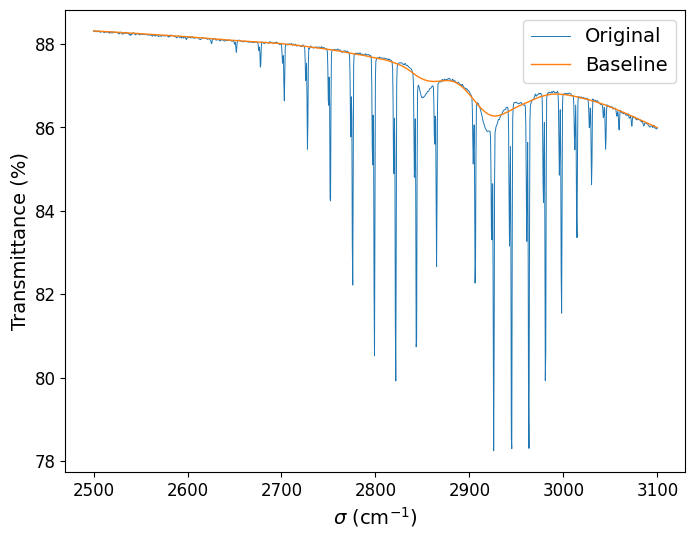

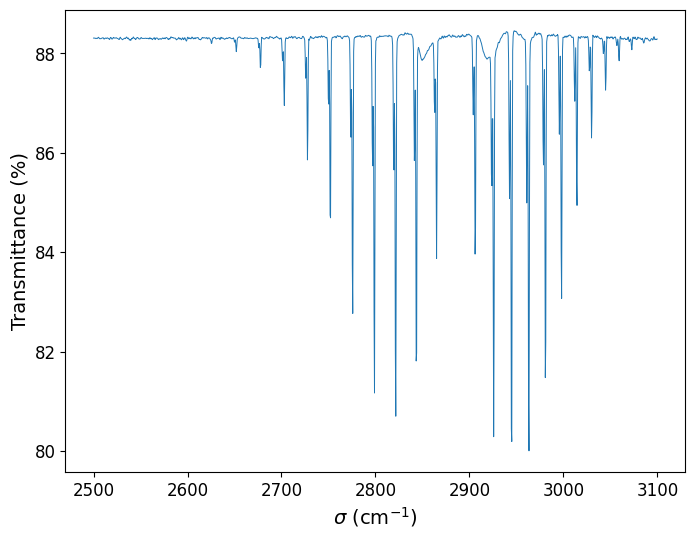

In [8]:
# Plot du spectre
fontsize = 14

plt.figure(1, figsize=(8, 6))
plt.plot(wavenumber_filtered, transmittance_filtered, label='Original', linewidth=0.7)
plt.plot(wavenumber_filtered, baseline, label='Baseline', linewidth=1)
plt.xlabel("$\sigma$ (cm$^{-1}$)", fontsize=fontsize)
plt.ylabel('Transmittance (%)', fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=fontsize)
plt.savefig('./Images/spectreHCl.eps', bbox_inches='tight')
plt.savefig('./Images/spectreHCl.svg', bbox_inches='tight')
plt.show()

plt.figure(2, figsize=(8, 6))
plt.plot(wavenumber_filtered, corrected_transmittance, label='Corrected', linewidth=0.7)
plt.xlabel("$\sigma$ (cm$^{-1}$)", fontsize=fontsize)
plt.ylabel('Transmittance (%)', fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./Images/spectreHCl_baseline_corrected.eps', bbox_inches='tight')
plt.savefig('./Images/spectreHCl_baseline_corrected.svg', bbox_inches='tight')
plt.show()


    Peak Position  Relative Maxima
0       2677.4821         0.071969
1       2701.1084         0.055931
2       2703.0371         0.164210
3       2725.6990         0.097935
4       2727.6277         0.295831
5       2750.2896         0.160632
6       2752.2182         0.436008
7       2773.9158         0.240746
8       2775.8445         0.667471
9       2797.0599         0.310117
10      2798.9886         0.860060
11      2819.7219         0.320047
12      2821.6505         0.916186
13      2841.4194         0.297515
14      2843.3481         0.782578
15      2849.6163         0.054989
16      2851.0628         0.051921
17      2863.1170         0.180766
18      2865.0457         0.534652
19      2904.1014         0.186688
20      2906.0300         0.523769
21      2918.5664         0.051741
22      2923.8703         0.358097
23      2925.7989         0.965818
24      2942.6748         0.389603
25      2945.0857         0.977448
26      2960.9972         0.399928
27      2963.4081   

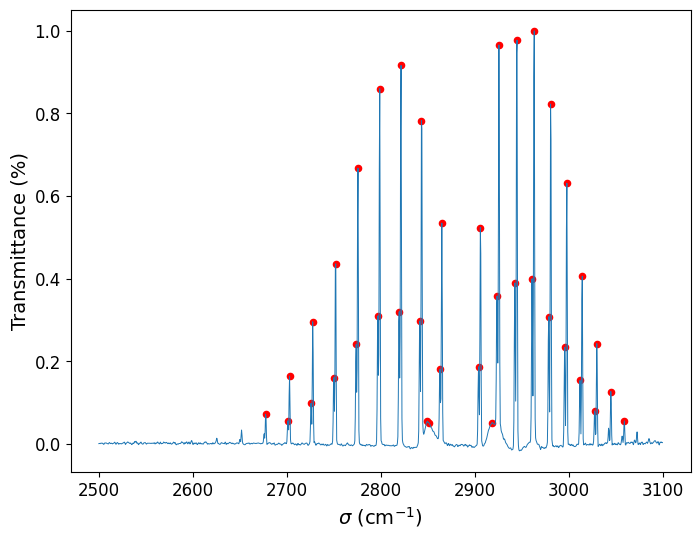

In [9]:
# Trouver les pics 
reversed_transmistance = baseline[0]-corrected_transmittance
norm_reversed_transmistance = reversed_transmistance/np.max(reversed_transmistance)


peaks, _ = find_peaks(norm_reversed_transmistance, height=0.05)


peak_positions = wavenumber_filtered[peaks]
relative_maxima = norm_reversed_transmistance[peaks]

data = {'Peak Position': peak_positions, 'Relative Maxima': relative_maxima}
peak_table = pd.DataFrame(data)
print(peak_table)

plt.figure(3, figsize=(8, 6))
plt.plot(wavenumber_filtered, norm_reversed_transmistance, label='Corrected', linewidth=0.7)
plt.scatter(wavenumber_filtered[peaks], norm_reversed_transmistance[peaks], label='Corrected', s=20, color = 'red')
plt.xlabel("$\sigma$ (cm$^{-1}$)", fontsize=fontsize)
plt.ylabel('Transmittance (%)', fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('./Images/spectreHCl_peaks.eps', bbox_inches='tight')
plt.savefig('./Images/spectreHCl_peaks.svg', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2701.1084 2.9359190972160514
2725.699 3.0206792800947286
2750.2896 2.7143294001269904
2773.9158 2.77250904060157
2797.0599 2.7733426397351355
2819.7219 2.8626581359936147
2841.4194 2.630384180505461
2863.117 2.9576979377932426
2904.1014 2.8055861793155232
2923.8703 2.6970882727368353
2942.6748 2.5088314399498115
2960.9972 2.5004508478300997
2978.8375 2.6717071808117425
2995.7134 2.7010011373359997
3012.1071 2.640779864191444
3027.5365 3.0339300449861324
Ratios moyens : 2.764


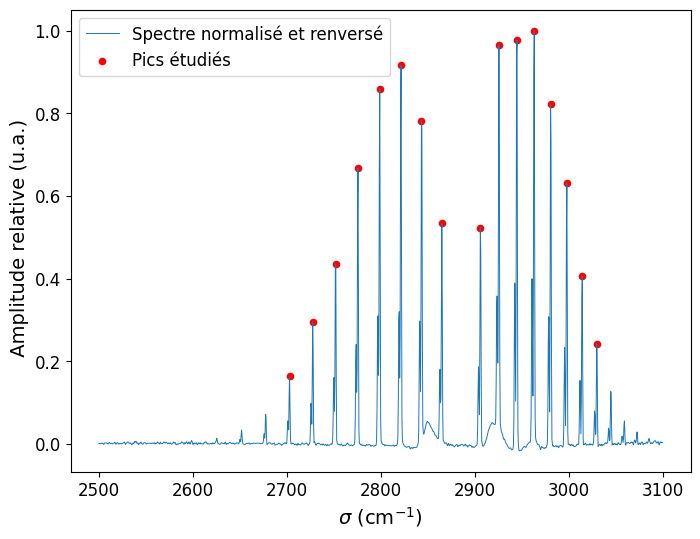

In [10]:
# Calcul des isotopes
skip_next = False
threshold = 3 #cm-1
ratios = []
highest_peaks_wavenumber=np.array([])
highest_peaks_maxima = np.array([])

for i in range(len(peak_positions)): 
    if skip_next:
        skip_next=False
        continue
    if i!=len(peak_positions)-1:
        if peak_positions[i+1]-peak_positions[i]<threshold and relative_maxima[i]>0.055 :
            ratios.append(relative_maxima[i+1]/relative_maxima[i])
            skip_next = True
            print(peak_positions[i], relative_maxima[i+1]/relative_maxima[i])
            # Commenter/ Décommenter pour afficher aussi les pics de l'isotope le moins abondant:
            # highest_peaks_wavenumber=np.append(highest_peaks_wavenumber, peak_positions[i])
            # highest_peaks_maxima=np.append(highest_peaks_maxima, relative_maxima[i])
            highest_peaks_wavenumber=np.append(highest_peaks_wavenumber, peak_positions[i+1])
            highest_peaks_maxima=np.append(highest_peaks_maxima, relative_maxima[i+1])
            continue


print(f'Ratios moyens : {np.average(ratios):.3f}')


plt.figure(4, figsize=(8, 6))
plt.plot(wavenumber_filtered, norm_reversed_transmistance, label='Spectre normalisé et renversé', linewidth=0.7)
plt.scatter(highest_peaks_wavenumber, highest_peaks_maxima, label='Pics étudiés', s=20, color = 'red')
plt.xlabel("$\sigma$ (cm$^{-1}$)", fontsize=fontsize)
plt.ylabel(' Amplitude relative (u.a.)', fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig('./Images/spectreHCl_peaks.eps', bbox_inches='tight')
plt.savefig('./Images/spectreHCl_peaks.svg', bbox_inches='tight')
plt.show()

## Énergie des pics et paramètres 

On calcul la différence des énergies $E_R$ et $E_P$ afin d'enlever la dépendance avec les modes vibrationnels 
$$ \Delta E_R(n_i=0, J_i) = \hbar \omega_e-2\hbar\omega_e x_e + (B_1+B_0)(J_i+1) + (B_1-B_0)(J_i+1)^2-4D(J_i+1)^3$$

$$ \Delta E_P(n_i=0, J_i) = \hbar \omega_e-2\hbar\omega_e x_e - (B_1+B_0)(J_i) + (B_1-B_0)J_i^2-4DJ_i^3$$

$$ =>\Delta E_R - \Delta E_R = 2B_1(2J_i+1) - 4D((J_i+1)^3+J_i^3) $$

On fait un fit de $E_R -E_P$ en fonction de $J_i$ pour obtenir les paramètres $B_1$ et $D$. Pour calculer $B_0$, on procède similairement en faisant $E_R(J-1)-E_P(J+1) : 

$$ =>\Delta E_R(J-1) - \Delta E_R(J+1) = 2B_0(2J_i+1) - 4D((J_i+1)^3+J_i^3) $$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0 2 2906.03 2843.3481 62.68190000000004
1 3 2925.7989 2821.6505 104.14839999999958
2 4 2945.0857 2798.9886 146.09709999999995
3 5 2963.4081 2775.8445 187.56359999999995
4 6 2980.7662 2752.2182 228.54800000000023
5 7 2998.1242 2727.6277 270.4965000000002
6 8 3014.518 2703.0371 311.4809


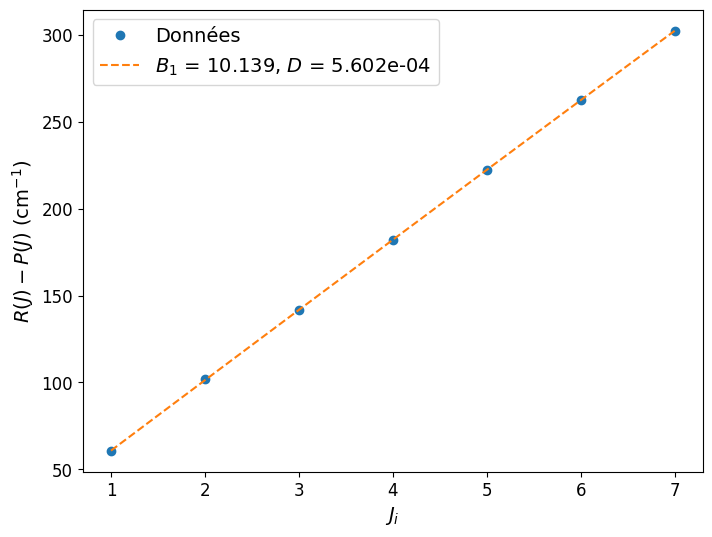

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


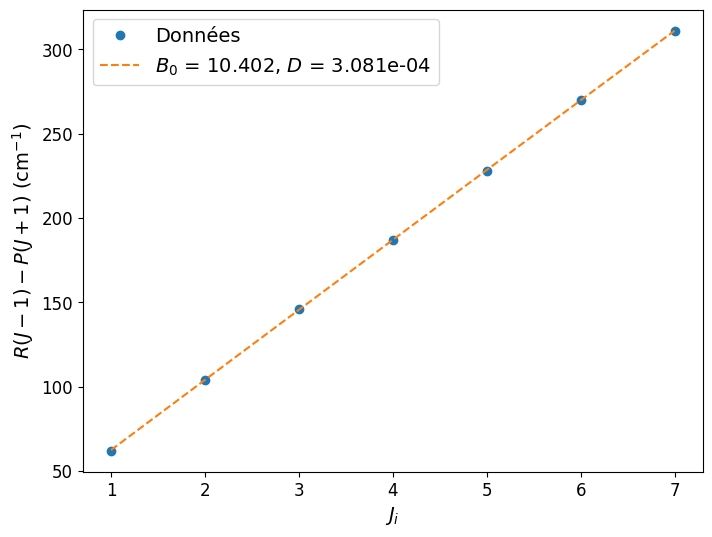

In [11]:
# Calcul des énergies (à compléter)
h = 6.626e-34
hbar = h/(2*np.pi)
c = 3e8
e = 1.6e-19

J = np.array([8,7,6,5,4,3,2,1,0,1,2,3,4,5,6,7])
m = np.array([-8,-7,-6,-5,-4,-3,-2,-1, 1,2,3,4,5,6,7,8 ])

peak_energy = highest_peaks_wavenumber#*1e2*h*c/e


def func(J, B1, D):
    return 2*B1*(2*J+1)-4*D*((J+1)**3+J**3)


P_J = J[:8][::-1]
R_J = J[8:]

J_i = R_J[1:]

P_energies = peak_energy[:8][::-1]
R_energies = peak_energy[8:]

R_minus_P = R_energies[1:]-P_energies[:-1]

params1, covariance1 = curve_fit(func, J_i, R_minus_P)
B1_fit, D_fit = params1

Rm1_Pp1 = np.empty(7, dtype=np.int32)
for i in range(1, len(R_energies)):
    Rm1_Pp1[i-1] = R_energies[i-1]-P_energies[i]
    print(R_J[i-1], P_J[i], R_energies[i-1], P_energies[i], R_energies[i-1]-P_energies[i])

params2, covariance2 = curve_fit(func, J_i, Rm1_Pp1)
B0_fit, D1_fit = params2

plt.figure(5, figsize=(8, 6))
plt.plot(J_i, R_minus_P, 'o', linewidth=0.7, label='Données')
plt.plot(J_i, func(J_i, B1_fit, D_fit), '--', label=f'$B_1$ = {B1_fit:.3f}, $D$ = {D_fit:.3e}')
plt.xlabel("$J_i$", fontsize=fontsize)
plt.ylabel('$R(J)-P(J)$ (cm$^{-1}$)', fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=fontsize)
plt.savefig('./Images/energy_B1.eps', bbox_inches='tight')
plt.savefig('./Images/energy_B1.svg', bbox_inches='tight')
plt.show()

plt.figure(6, figsize=(8, 6))
plt.plot(J_i, Rm1_Pp1, 'o', linewidth=0.7, label='Données')
plt.plot(J_i, func(J_i, B0_fit, D1_fit), '--', label=f'$B_0$ = {B0_fit:.3f}, $D$ = {D1_fit:.3e}')
plt.xlabel("$J_i$", fontsize=fontsize)
plt.ylabel('$R(J-1)-P(J+1)$ (cm$^{-1}$)', fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=fontsize)
plt.savefig('./Images/energy_B0.eps', bbox_inches='tight')
plt.savefig('./Images/energy_B0.svg', bbox_inches='tight')
plt.show()
